这一章第一部分我们将实现K-means聚类算法，用于图像压缩；第二部分使用PCA，将人脸图像以低维度的方式表征

## 1. K-means Clustering

### 1.1 implementing K-means

K-means算法是自动将相似的数据聚集在一类，属于非监督分类。最关键的一步是寻找合适的聚类中心。

#### 1.1.1 finding closet centoids

$C^{\left( i\right) }:=j$ that minimizes: $ \left| \right| x^{\left( i\right) }-\mu _{j}\left| \right|^{2}$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [2]:
def min_distance_index(x, centroids):
    k = centroids.shape[0]
    dist_array = np.zeros(k)
    for i in range(k):
        distance = np.sum((x - centroids[i])**2)
        dist_array[i] = distance
    return dist_array.argmin()

In [11]:
def find_closet_centoids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    # 存储类别信息
    idx = []
    
    for i in range(m):
        idx.append(min_distance_index(X[i], centroids))
    return np.array(idx)

测试一下，看看效果

In [90]:
data = loadmat('ex7data2.mat')
X = data['X']
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closet_centoids(X, initial_centroids)
idx[:3]

array([0, 2, 1], dtype=int64)

#### 1.1.2 computing centroid means

计算新的聚类中心：$\mu _{k}:\dfrac {1}{\left| c_{k}\right| }\sum _{i\in C_{k}}x^{\left( i\right) }_{k}$

In [91]:
data2 = pd.DataFrame(X, columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


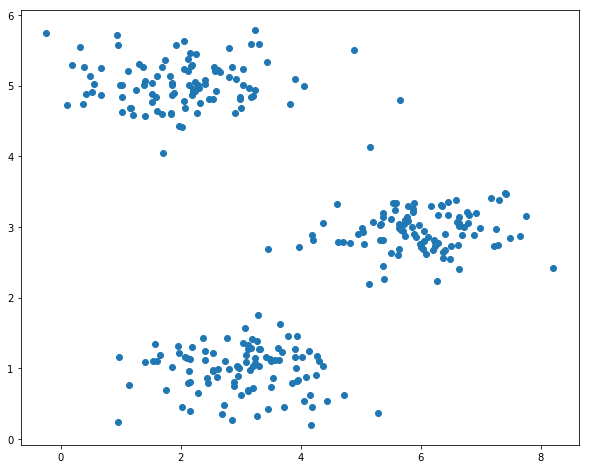

In [46]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data2['X1'], data2['X2'])
plt.show()

In [94]:
# 与其用循环，不如借助矢量化操作提高效率
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    for i in range(k):
        centroids[i] = X[idx == i].mean(axis=0)
    return centroids

In [95]:
compute_centroids(X, idx, 3)

array([[ 2.42830111,  3.15792418],
       [ 5.81350331,  2.63365645],
       [ 7.11938687,  3.6166844 ]])

### 1.2 K-means on example dataset

In [81]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closet_centoids(X, centroids)
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [97]:
idx, centroids = run_k_means(X, initial_centroids, 10)
centroids

array([[ 1.95399466,  5.02557006],
       [ 3.04367119,  1.01541041],
       [ 6.03366736,  3.00052511]])

可以绘制出来看一看效果

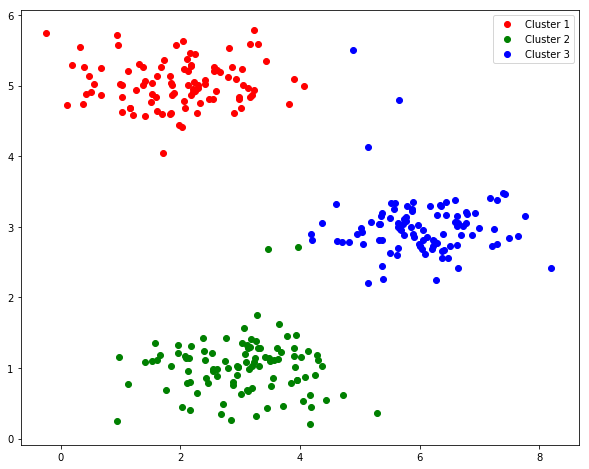

In [98]:
cluster1 = data2[idx == 0]
cluster2 = data2[idx == 1]
cluster3 = data2[idx == 2]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(cluster1['X1'], cluster1['X2'], c='r', label='Cluster 1')
ax.scatter(cluster2['X1'], cluster2['X2'], c='g', label='Cluster 2')
ax.scatter(cluster3['X1'], cluster3['X2'], c='b', label='Cluster 3')
plt.legend(loc='best')
plt.show()

其实有些类别是误分的，这和迭代的次数，和初始聚类中心的设置都有关系

### 1.3 random initialization

实际的应用中，最开始的聚类中心应该是随机多次，选择最合适的一个。

In [99]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        centroids[i] = X[idx[i]]
    return centroids

In [100]:
init_centroids(X, 3)

array([[ 5.132009  ,  2.19812195],
       [ 2.05670542,  5.23391326],
       [ 4.43152976,  0.54041   ]])

就可以用该初始聚类中心重新计算

### 1.4 image compression with K-means

In [103]:
import matplotlib.image as mpimg

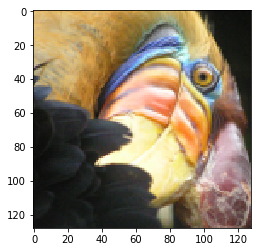

In [106]:
img = mpimg.imread('bird_small.png')
plt.imshow(img)
plt.show()

#### 1.4.1 K-means on pixels

In [108]:
img.shape

(128, 128, 3)

对数据进行一些与处理操作

In [114]:
# normalize value ranges
data3 = img.copy()

data3 = data3 / 255

# reshape
data3 = np.reshape(data3, (data3.shape[0] * data3.shape[1], data3.shape[2]))

data3.shape

(16384, 3)

In [123]:
# randomly initialize the centroids
initial_centroids = init_centroids(data3, 16)

# run the algorithm
idx, centroids = run_k_means(data3, initial_centroids, 10)

# map each pixel to the centroid value
recovered = centroids[id), :]
recovered.shape

array([[ 0.00336584,  0.00260786,  0.00149115],
       [ 0.00340003,  0.00288826,  0.00196186],
       [ 0.00340003,  0.00288826,  0.00196186],
       ..., 
       [ 0.00067833,  0.00067619,  0.00064494],
       [ 0.00067833,  0.00067619,  0.00064494],
       [ 0.00067833,  0.00067619,  0.00064494]])

In [120]:
# reshape to original dimensions
recovered = np.reshape(recovered, (img.shape[0], img.shape[1], img.shape[2]))
recovered.shape

(128, 128, 3)

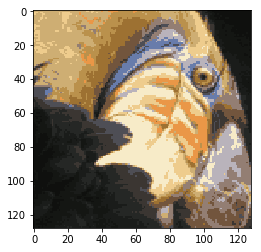

In [124]:
plt.imshow(recovered * 255)
plt.show()

## 2 Principal Component Analysis

主成分分析是在数据集中找到具有最大方差的方向，目的是降维，提高机器学习的速度

### 2.1 example dataset

In [74]:
data = loadmat('ex7data1.mat')
X = data['X']
data4 = pd.DataFrame(X, columns=['X1', 'X2'])
data4.head()

,X1,X2
0,3.381563,3.389113
1,4.527875,5.854178
2,2.655682,4.411995
3,2.765235,3.715414
4,2.846560,4.175506


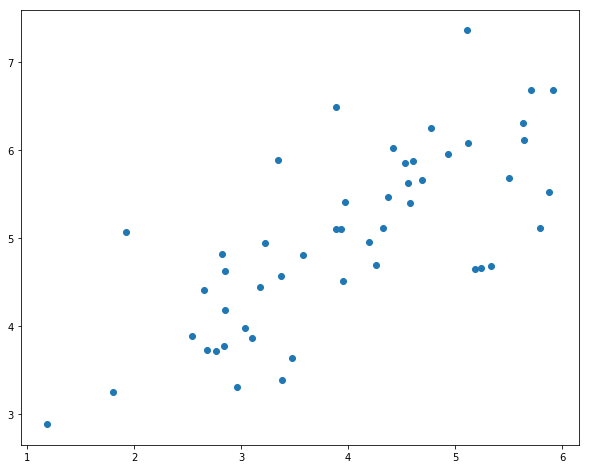

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data4['X1'], data4['X2'])
plt.show()

### 2.2 implementing PCA

计算PCA主要分为两步，首先计算协方差矩阵，其次利用SVD分解计算特征向量，这就是对应着的主成分。
> 注意：在使用PCA之前，数据的归一化很重要，避免尺度的影响

协方差矩阵：$\Sigma =\dfrac {1}{m}X^{T}X$

In [78]:
def pca(X):
    m = X.shape[0]
    # normalize
    X = (X - X.mean()) / X.std()
    
    # covariance matrix
    X = np.mat(X)
    sigma = (X.T * X) / m
    
    # SVD
    U, S, V = np.linalg.svd(sigma)
    
    return U, S, V

In [79]:
U, S, V = pca(data4)
U, S, V

(matrix([[-0.70710678, -0.70710678],
         [-0.70710678,  0.70710678]]),
 array([ 1.70081977,  0.25918023]),
 matrix([[-0.70710678, -0.70710678],
         [-0.70710678,  0.70710678]]))

主成分对应的就是矩阵U，利用这个矩阵就可以将原始数据投影到迪维空间

### 2.3 dimesnsionality reduction with PCA

#### 2.3.1 projecting the data onto the principal components

In [80]:
def project_data(X, U, k):
    U_reduced = U[:, :k]
    return np.dot(X, U_reduced)

In [81]:
Z = project_data(X, U, 1)
Z

matrix([[-4.78759045],
        [-7.34122042],
        [-4.99760204],
        [-4.58251038],
        [-4.96535088],
        [-7.33909864],
        [-5.02657745],
        [-8.90393595],
        [-6.38329374],
        [-7.20197778],
        [-7.05107253],
        [-6.95290959],
        [-6.4674726 ],
        [-7.00429773],
        [-4.66963233],
        [-8.4480763 ],
        [-7.3196659 ],
        [-5.28701594],
        [-8.81999314],
        [-6.95020407],
        [-8.75989905],
        [-5.92729807],
        [-8.315444  ],
        [-6.33065452],
        [-4.54033809],
        [-5.77450612],
        [-7.69650922],
        [-7.70841907],
        [-5.39933015],
        [-6.35631705],
        [-6.53101334],
        [-8.06183103],
        [-4.92218554],
        [-7.0797285 ],
        [-5.61499734],
        [-7.8001156 ],
        [-4.53023245],
        [-7.90528254],
        [-3.56709632],
        [-6.67057627],
        [-7.38689297],
        [-5.3854378 ],
        [-4.95846894],
        [-7

#### 2.3.2 reconstructiing an approximation of the data

可以通过矩阵变换，将数据从低维空间恢复的高维空间

In [84]:
def recovered(Z, U, k):
    U_reduced = U[:, :k]
    return np.dot(Z, U_reduced.I)

In [87]:
X_recovered = recovered(Z, U, 1)
X_recovered, X

(matrix([[ 3.38533768,  3.38533768],
         [ 5.19102674,  5.19102674],
         [ 3.53383829,  3.53383829],
         [ 3.24032416,  3.24032416],
         [ 3.51103328,  3.51103328],
         [ 5.18952641,  5.18952641],
         [ 3.554327  ,  3.554327  ],
         [ 6.29603349,  6.29603349],
         [ 4.51367029,  4.51367029],
         [ 5.09256733,  5.09256733],
         [ 4.9858612 ,  4.9858612 ],
         [ 4.91644952,  4.91644952],
         [ 4.57319373,  4.57319373],
         [ 4.95278642,  4.95278642],
         [ 3.30192868,  3.30192868],
         [ 5.97369204,  5.97369204],
         [ 5.17578539,  5.17578539],
         [ 3.73848482,  3.73848482],
         [ 6.23667696,  6.23667696],
         [ 4.91453643,  4.91453643],
         [ 6.19418402,  6.19418402],
         [ 4.19123266,  4.19123266],
         [ 5.87990684,  5.87990684],
         [ 4.47644874,  4.47644874],
         [ 3.21050385,  3.21050385],
         [ 4.08319244,  4.08319244],
         [ 5.44225386,  5.44225386],
 

#### 2.3.3 visualizeing the projections

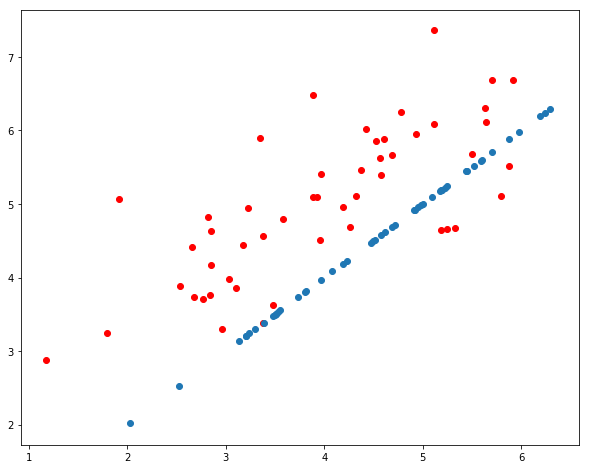

In [93]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(X[:, 0], X[:, 1], c='r')
ax.scatter(list(X_recovered[:, 0]), list(X_recovered[:, 1]))
plt.show()

### 2.4 face image dataset

In [94]:
faces = loadmat('ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [115]:
def plot_n_images(X, n):
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))
    
    images = X[:n, :]
    
    fig, ax = plt.subplots(nrows=grid_size, ncols=grid_size, sharex=True, sharey=True, figsize=(8, 8))
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(images[i * grid_size + j].reshape(pic_size, pic_size).T, cmap='gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

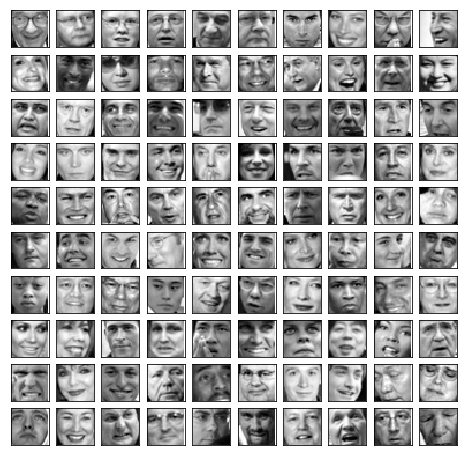

In [117]:
plot_n_images(X, 100)

#### 2.4.1 PCA and faces

In [102]:
# normalize
X_norm = X.copy()
X_norm = (X_norm - X_norm.mean(axis=0)) / X_norm.std(axis=0)

In [103]:
# SVD
U, S, V = pca(X_norm)
U.shape

(1024, 1024)

#### 2.4.2 dimensionality reduction

In [108]:
Z = project_data(X_norm, U, 100)
Z

matrix([[ 15.11610674,   4.98929978,   5.77207788, ...,  -0.38343217,
          -1.55237011,   1.52029451],
        [  9.95426448,  -3.44602524,   6.15743438, ...,  -0.43996358,
          -0.11981076,   1.33334794],
        [ -7.69870069,  -6.23895468,   1.13313022, ...,   0.93193166,
           1.98754057,   1.31011903],
        ..., 
        [ 15.61313925,  13.52807232, -16.95548895, ...,   0.33723595,
           0.99185197,   0.71934132],
        [ 37.43251456,  -2.62632027,  -0.28874067, ...,  -0.45375381,
          -0.53783725,   0.44894347],
        [ 11.7937156 ,   2.92058782,  -2.58125614, ...,  -0.70455426,
           0.33624308,   0.10535825]])

In [109]:
# recover
recovered = recovered(Z, U, 100)
recovered

matrix([[-0.24050631, -0.26139662, -0.30137928, ..., -0.54852901,
         -0.25372376,  0.00390558],
        [ 0.29817618,  0.31019666,  0.28052837, ...,  0.02200277,
          0.19015989,  0.27579546],
        [-0.1840427 , -0.18491739, -0.11549109, ..., -1.37465126,
         -1.37434749, -1.30979498],
        ..., 
        [-0.22367107, -0.20022414, -0.17944088, ...,  1.98818818,
          2.18488511,  2.2316776 ],
        [ 0.50217193,  0.60008965,  0.72716409, ..., -0.54895318,
         -0.51925237, -0.47859556],
        [-1.85141474, -1.93195571, -1.9672026 , ...,  0.80672824,
          0.92164314,  0.91739337]])

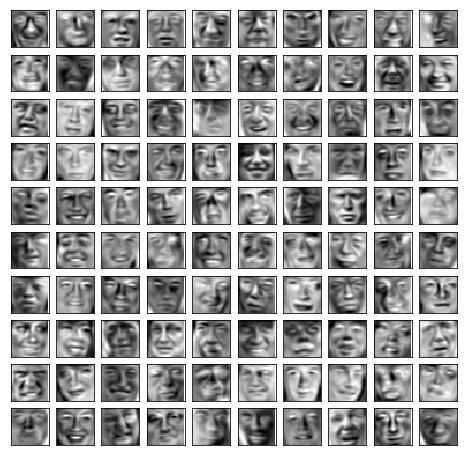

In [118]:
plot_n_images(recovered, 100)

可以从结果清晰的看出来，主要特征还在，但是的确变得模糊了。这样就可以提高机器学习的速度和效率了！